In [1]:
# import of necessary files from other folders

import os
import sys

# libraries imports

import importlib
import numpy as np
import matplotlib.pyplot as plt
import tempfile
import seaborn as sns
import pandas as pd
import pickle

from IPython.display import Image, display
from PIL import Image
from pathlib import Path
from scipy.integrate import solve_ivp
from matplotlib.colors import LinearSegmentedColormap,TwoSlopeNorm

import definitions
import well_mixed




# Analyze networks from CR_generation

In [2]:
# Function to check if a string can be converted to a float or an integer
def is_number(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

# Path to the results directory
results_directory_path = Path('/Users/federicasibilla/Documenti/Tesi/A15_200nets/selected_results')

# Definition of DataFrame columns
columns = ['n_resources','n_supplied','n_consumed','leakage','replenishment','sparsity','abundances','LV','A','g']
df_complete = pd.DataFrame(columns=columns)

# List to accumulate the data
rows = []

# Get all folders and sort them alphabetically
folders = sorted(results_directory_path.iterdir(), key=lambda x: x.name)

# Loop over all items in the sorted list of folders
for folder in folders:
    if folder.is_dir():

        parameters = folder.name
        
        # Check and convert only the parts that can be numbers (floats or integers)
        parameters_list = [float(value) if '.' in value else int(value) for value in parameters.split('_') if is_number(value)]
        
        # Construct the full path of the pickle file
        pickle_file_path = folder / 'all_data.pkl'
        
        if pickle_file_path.exists():
            # Load data from the pickle file
            with open(pickle_file_path, 'rb') as file:
                data = pickle.load(file)
        
        final_fraction = data['CR_N']
        LV = data['LV']
        g = data['g0']
        A = data['A']
        
        # Create a new row and add it to the rows list
        new_row = parameters_list + [final_fraction]+ [LV] + [A] + [g]
        rows.append(new_row)

# Create a new DataFrame with the accumulated rows
df_complete = pd.concat([df_complete, pd.DataFrame(rows, columns=columns)], ignore_index=True)

In [3]:
df_complete.head(1)

,n_resources,n_supplied,n_consumed,leakage,replenishment,sparsity,abundances,LV,A,g
0,17.0,1.0,1.0,0.2,100.0,0.4,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0....","[[1.0, 0.9923454302527422, 0.9852128819427427,...","[[-0.07656250000142066, 0.0011238965117239305,...","[-0.008750000000194835, -0.008750001870636286,..."


In [4]:
from scipy.stats import entropy

# Define a function to calculate Shannon diversity index
def shannon_diversity(abundance_list):
    # Extract the last abundance list
    last_abundance = abundance_list[-1]
    # Calculate Shannon diversity index
    return entropy(last_abundance, base=np.e)

# Apply the function to compute Shannon diversity and add it as a new column
df_complete['shannon'] = df_complete['abundances'].apply(shannon_diversity)

df_complete.head(1)

,n_resources,n_supplied,n_consumed,leakage,replenishment,sparsity,abundances,LV,A,g,shannon
0,17.0,1.0,1.0,0.2,100.0,0.4,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0....","[[1.0, 0.9923454302527422, 0.9852128819427427,...","[[-0.07656250000142066, 0.0011238965117239305,...","[-0.008750000000194835, -0.008750001870636286,...",0.482909


In [5]:
df_complete['difference'] = [matrix[:, -1] - matrix2[-1] for matrix,matrix2 in zip(df_complete['LV'],df_complete['abundances'])]

In [6]:
df_filtered = df_complete[df_complete['difference'].apply(lambda x: (np.sum(x)/8 < 1))]
len(df_filtered)

190

In [7]:
from scipy.stats import entropy

# Define a function to calculate Shannon diversity index
def richness_diversity(abundance_list):
    # Extract the last abundance list
    last_abundance = np.sum(abundance_list[-1]>1e-3)
    # Calculate Shannon diversity index
    return last_abundance

# Apply the function to compute Shannon diversity and add it as a new column
df_complete['richness'] = df_complete['abundances'].apply(richness_diversity)

df_complete.head(1)

,n_resources,n_supplied,n_consumed,leakage,replenishment,sparsity,abundances,LV,A,g,shannon,difference,richness
0,17.0,1.0,1.0,0.2,100.0,0.4,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0....","[[1.0, 0.9923454302527422, 0.9852128819427427,...","[[-0.07656250000142066, 0.0011238965117239305,...","[-0.008750000000194835, -0.008750001870636286,...",0.482909,"[0.00016224303644918336, 3.746528784168146e-06...",7


/var/folders/cz/ql9y2c0d30jfv4_wzd2p0bpw0000gn/T/ipykernel_16480/994520866.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust to accommodate the colorbar


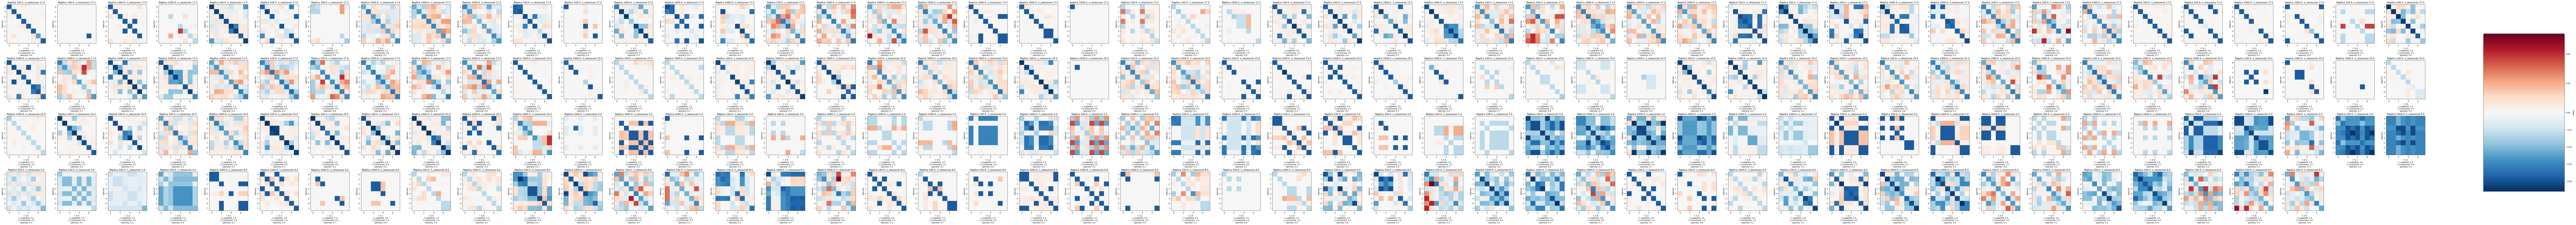

In [14]:

# Define a colormap with white at zero
colormap = 'RdBu_r'

# Calculate global vmin and vmax for consistent color scaling
all_A_values = np.concatenate([np.ravel(A) for A in df_complete['A']])
vmin, vmax = np.min(all_A_values), np.max(all_A_values)

# Create TwoSlopeNorm for normalization
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Calculate number of rows and columns for subplots
num_plots = len(df_filtered)
num_rows = int(4)
num_columns = int(np.ceil(num_plots / num_rows))

# Create a figure with the appropriate size for subplots
fig, axs = plt.subplots(num_rows, num_columns, figsize=(num_columns*4, num_rows*4))

# Ensure axs is a 2D array even for single rows/columns
axs = axs.reshape(num_rows, num_columns)

# Flatten the axs array for easier indexing
axs = axs.flatten()

# Iterate through the dataframe and plot each matrix
for idx, (i, row) in enumerate(df_filtered.iterrows()):
    if idx >= len(axs):
        break  # Skip if there are more plots than subplots
    
    # Get the subplot
    ax = axs[idx]
    
    # Plot the matrix in the correct subplot
    A_int = row['A']
    
    # Plot the interaction matrix with the custom diverging colormap
    im = ax.imshow(A_int, cmap=colormap, norm=norm)
    
    # Set titles and labels with parameters for each plot
    ax.set_title(f"Replica {row['replenishment']}, n_resources {row['n_resources']}")
    ax.set_xlabel(f"l: {row['leakage']}\nn_supplied: {row['n_supplied']}\nn_consumed: {row['n_consumed']}\nsparsity: {row['sparsity']}")
    ax.set_ylabel('Species')

# Remove unused subplots
for ax in axs[len(df_filtered):]:
    fig.delaxes(ax)

# Add a single colorbar for all subplots
cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])  # Adjust the position and size as needed
cbar = plt.colorbar(im, cax=cbar_ax)
cbar.set_label('Value')

# Adjust layout to prevent overlap and ensure the figure fits well
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust to accommodate the colorbar

# Show the plot
plt.show()

# Comparison

In [8]:
# Definition of DataFrame columns
columns = ['n_resources','n_supplied','n_consumed','leakage','replenishment','sparsity','C','D','A']
df_compare = pd.DataFrame(columns=columns)

# List to accumulate the data
rows = []

# Get all folders and sort them alphabetically
folders = sorted(results_directory_path.iterdir(), key=lambda x: x.name)

# Loop over all items in the sorted list of folders
for folder in folders:
    if folder.is_dir():

        parameters = folder.name
        
        # Check and convert only the parts that can be numbers (floats or integers)
        parameters_list = [float(value) if '.' in value else int(value) for value in parameters.split('_') if is_number(value)]
        
        # Construct the full path of the pickle file
        pickle_file_path = folder / 'all_data.pkl'
        
        if pickle_file_path.exists():
            # Load data from the pickle file
            with open(pickle_file_path, 'rb') as file:
                data = pickle.load(file)
    
        C = data['uptake']
        D = data['D']
        A = data['A']
        
        # Create a new row and add it to the rows list
        new_row = parameters_list + [C] +[D] + [A]
        rows.append(new_row)

# Create a new DataFrame with the accumulated rows
df_compare = pd.concat([df_compare, pd.DataFrame(rows, columns=columns)], ignore_index=True)

In [9]:
# Merge the DataFrames on the common columns
merged_df = pd.merge(
    df_filtered, df_compare,
    how='inner',  # Only include rows that are common in both DataFrames
    on=['n_resources', 'n_supplied', 'n_consumed', 'leakage','replenishment', 'sparsity']  # Columns to match
)

In [10]:
len(merged_df)

190

In [13]:
merged_df.head(1)

,n_resources,n_supplied,n_consumed,leakage,replenishment,sparsity,abundances,LV,A_x,g,shannon,difference,C,D,A_y
0,17.0,1.0,1.0,0.2,100.0,0.4,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0....","[[1.0, 0.9923454302527422, 0.9852128819427427,...","[[-0.07656250000142066, 0.0011238965117239305,...","[-0.008750000000194835, -0.008750001870636286,...",0.482909,"[0.00016224303644918336, 3.746528784168146e-06...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[-0.07656250000142066, 0.0011238965117239305,..."


In [15]:
merged_df['normalized_C']=merged_df['C'].apply(lambda x: x/np.sum(x,axis=1)[:,np.newaxis])

In [16]:
merged_df.head(1)

,n_resources,n_supplied,n_consumed,leakage,replenishment,sparsity,abundances,LV,A_x,g,shannon,difference,C,D,A_y,normalized_C
0,17.0,1.0,1.0,0.2,100.0,0.4,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0....","[[1.0, 0.9923454302527422, 0.9852128819427427,...","[[-0.07656250000142066, 0.0011238965117239305,...","[-0.008750000000194835, -0.008750001870636286,...",0.482909,"[0.00016224303644918336, 3.746528784168146e-06...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[-0.07656250000142066, 0.0011238965117239305,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,..."


In [11]:
#------------------------------------------------------------------------------------------------------------------------------
# calculate_C: function to quantify competition in a network

def calculate_C(C_matrix):

    """
    C_matrix: matrix, n_sxn_r, uptake matrix

    RETURNS C: float, value quantifying competition in a network
    """

    return np.mean(np.dot(C_matrix,C_matrix.T))

#------------------------------------------------------------------------------------------------------------------------------
# calculate_C: function to quantify competition in a network

def calculate_F(D_matrix,C_matrix):

    """
    C_matrix: matrix, n_sxn_r, uptake matrix

    RETURNS C: float, value quantifying competition in a network
    """


    return np.mean(np.dot(C_matrix,np.dot(D_matrix,C_matrix.T)))

In [17]:
# Apply the functions to the C and D columns and create new columns 'competition' and 'facilitation'
merged_df['competition'] = merged_df['normalized_C'].apply(lambda C_matrix: calculate_C(np.array(C_matrix)))
merged_df['facilitation'] = merged_df.apply(lambda row: calculate_F(np.array(row['D']), np.array(row['normalized_C'])), axis=1)

In [18]:
merged_df.head(1)

,n_resources,n_supplied,n_consumed,leakage,replenishment,sparsity,abundances,LV,A_x,g,shannon,difference,C,D,A_y,normalized_C,competition,facilitation
0,17.0,1.0,1.0,0.2,100.0,0.4,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0....","[[1.0, 0.9923454302527422, 0.9852128819427427,...","[[-0.07656250000142066, 0.0011238965117239305,...","[-0.008750000000194835, -0.008750001870636286,...",0.482909,"[0.00016224303644918336, 3.746528784168146e-06...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[-0.07656250000142066, 0.0011238965117239305,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...",0.125,0.0633


In [19]:
# Function to count positive and negative entries in a matrix
def count_pos_neg_entries(A_matrix):
    """
    A_matrix: matrix, n_sxn_r, interaction matrix
    
    RETURNS: list with two elements [num_positive, num_negative]
    """
    A_matrix = np.array(A_matrix)  # Convert the list to a numpy array
    num_positive = np.sum(A_matrix >= 0)
    num_negative = np.sum(A_matrix < 0)
    return [num_positive, num_negative]

# Apply the function to the 'A' column and create a new column 'pos_neg_counts'
merged_df['pos_neg_counts'] = merged_df['A_x'].apply(lambda A_matrix: count_pos_neg_entries(A_matrix))

In [20]:
merged_df['net_competition'] = merged_df['competition'] - merged_df['facilitation']
merged_df['fraction_pos'] = merged_df['pos_neg_counts'].apply(lambda x: x[0]/64)  # positive fraction
merged_df['fraction_neg'] = merged_df['pos_neg_counts'].apply(lambda x: x[1]/64)  # negative fraction

Pearson correlation (Competition, Fraction Negative): PearsonRResult(statistic=-0.02702723962573816, pvalue=0.7112677343434477)
Pearson correlation (Facilitation, Fraction Positive): PearsonRResult(statistic=-0.41414308678283485, pvalue=2.854264845187179e-09)
Pearson correlation (Net Competition, Fraction Positive): PearsonRResult(statistic=0.344988902984064, pvalue=1.0911248768187978e-06)


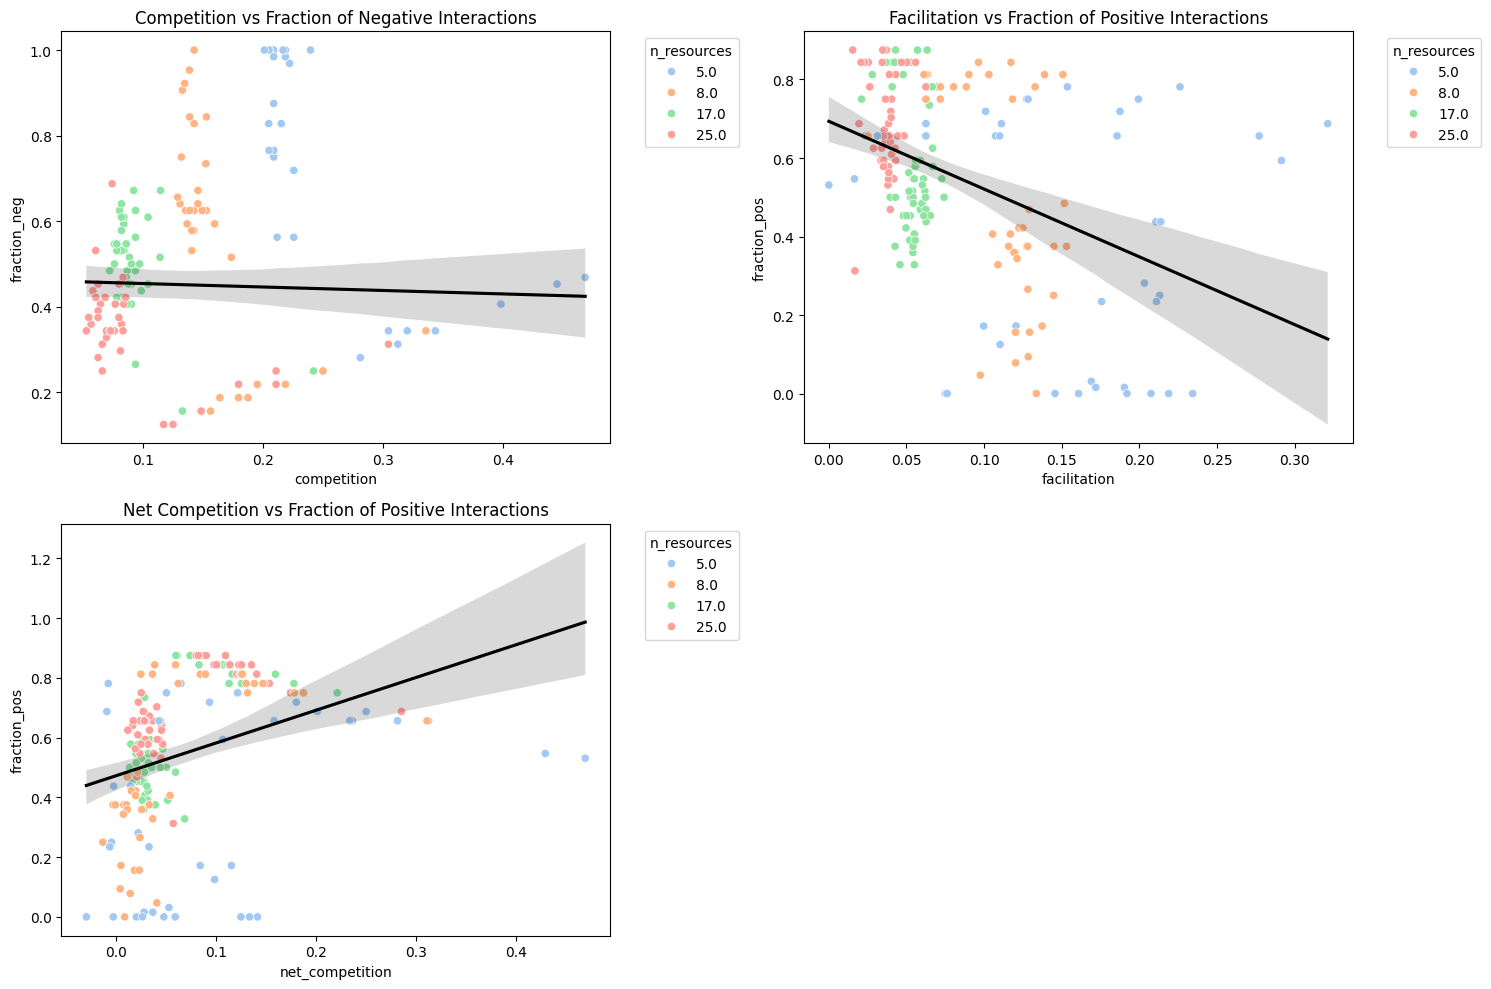

In [21]:
from scipy.stats import pearsonr

# Define a color palette with enough colors for distinct n_resources values
palette = sns.color_palette("pastel", n_colors=merged_df['n_resources'].nunique())

plt.figure(figsize=(15, 10))

## Competition vs Fraction Negative
plt.subplot(2, 2, 1)
sns.scatterplot(x='competition', y='fraction_neg', hue='n_resources', data=merged_df, palette=palette, legend='full')
sns.regplot(x='competition', y='fraction_neg', data=merged_df, scatter=False, color='black')
plt.title('Competition vs Fraction of Negative Interactions')
plt.legend(title='n_resources', bbox_to_anchor=(1.05, 1), loc='upper left')

# Facilitation vs Fraction Positive
plt.subplot(2, 2, 2)
sns.scatterplot(x='facilitation', y='fraction_pos', hue='n_resources', data=merged_df, palette=palette, legend='full')
sns.regplot(x='facilitation', y='fraction_pos', data=merged_df, scatter=False, color='black')
plt.title('Facilitation vs Fraction of Positive Interactions')
plt.legend(title='n_resources', bbox_to_anchor=(1.05, 1), loc='upper left')

# Net Competition vs Fraction Positive
plt.subplot(2, 2, 3)
sns.scatterplot(x='net_competition', y='fraction_pos', hue='n_resources', data=merged_df, palette=palette, legend='full')
sns.regplot(x='net_competition', y='fraction_pos', data=merged_df, scatter=False, color='black')
plt.title('Net Competition vs Fraction of Positive Interactions')
plt.legend(title='n_resources', bbox_to_anchor=(1.05, 1), loc='upper left')

# Correlation values
print("Pearson correlation (Competition, Fraction Negative):", pearsonr(merged_df['competition'], merged_df['fraction_neg']))
print("Pearson correlation (Facilitation, Fraction Positive):", pearsonr(merged_df['facilitation'], merged_df['fraction_pos']))
print("Pearson correlation (Net Competition, Fraction Positive):", pearsonr(merged_df['net_competition'], merged_df['fraction_pos']))

plt.tight_layout()
plt.show()

/var/folders/cz/ql9y2c0d30jfv4_wzd2p0bpw0000gn/T/ipykernel_52819/4682443.py:18: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.scatterplot(x='facilitation', y='residuals_competition', hue='n_consumed', data=merged_df, palette=palette, legend='full')


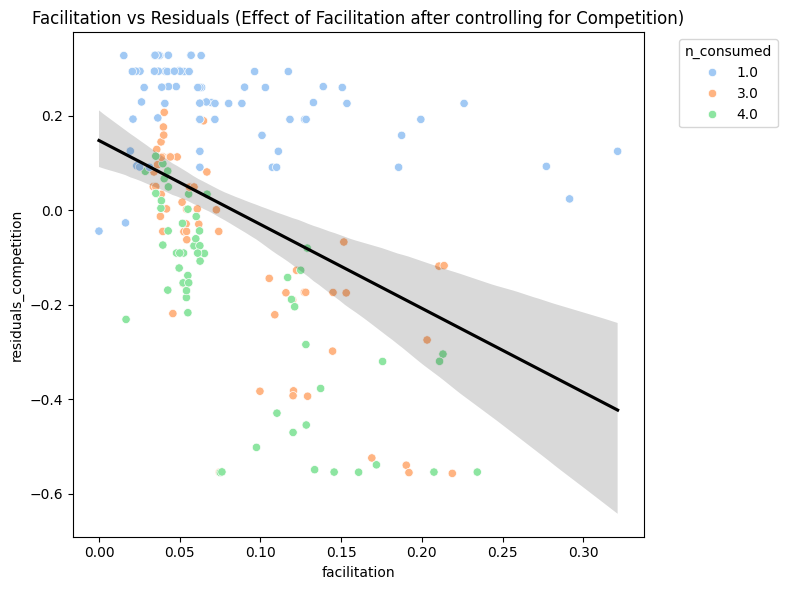

Pearson correlation (Facilitation, Residuals from Competition): -0.4262
P-value: 8.7492e-10


In [22]:
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# 1. Modello di regressione: Fraction Positive ~ Competition
X_competition = merged_df[['competition']]
X_competition = sm.add_constant(X_competition)  # Aggiungiamo l'intercetta
y = merged_df['fraction_pos']

model_competition = sm.OLS(y, X_competition).fit()

# 2. Otteniamo i residui dal modello solo con la competizione
merged_df['residuals_competition'] = model_competition.resid

# 3. Plottiamo i residui rispetto alla facilitazione
plt.figure(figsize=(8, 6))
sns.scatterplot(x='facilitation', y='residuals_competition', hue='n_consumed', data=merged_df, palette=palette, legend='full')
sns.regplot(x='facilitation', y='residuals_competition', data=merged_df, scatter=False, color='black')
plt.title('Facilitation vs Residuals (Effect of Facilitation after controlling for Competition)')
plt.legend(title='n_consumed', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# 4. Calcoliamo il coefficiente di Pearson e il p-value
pearson_coef, p_value = pearsonr(merged_df['facilitation'], merged_df['residuals_competition'])

# 5. Stampiamo i risultati
print(f"Pearson correlation (Facilitation, Residuals from Competition): {pearson_coef:.4f}")
print(f"P-value: {p_value:.4e}")

Pearson correlation (Competition, Fraction Negative): PearsonRResult(statistic=-0.02702723962573816, pvalue=0.7112677343434477)
Pearson correlation (Facilitation, Fraction Positive): PearsonRResult(statistic=-0.41414308678283485, pvalue=2.854264845187179e-09)
Pearson correlation (Net Competition, Fraction Positive): PearsonRResult(statistic=0.344988902984064, pvalue=1.0911248768187978e-06)


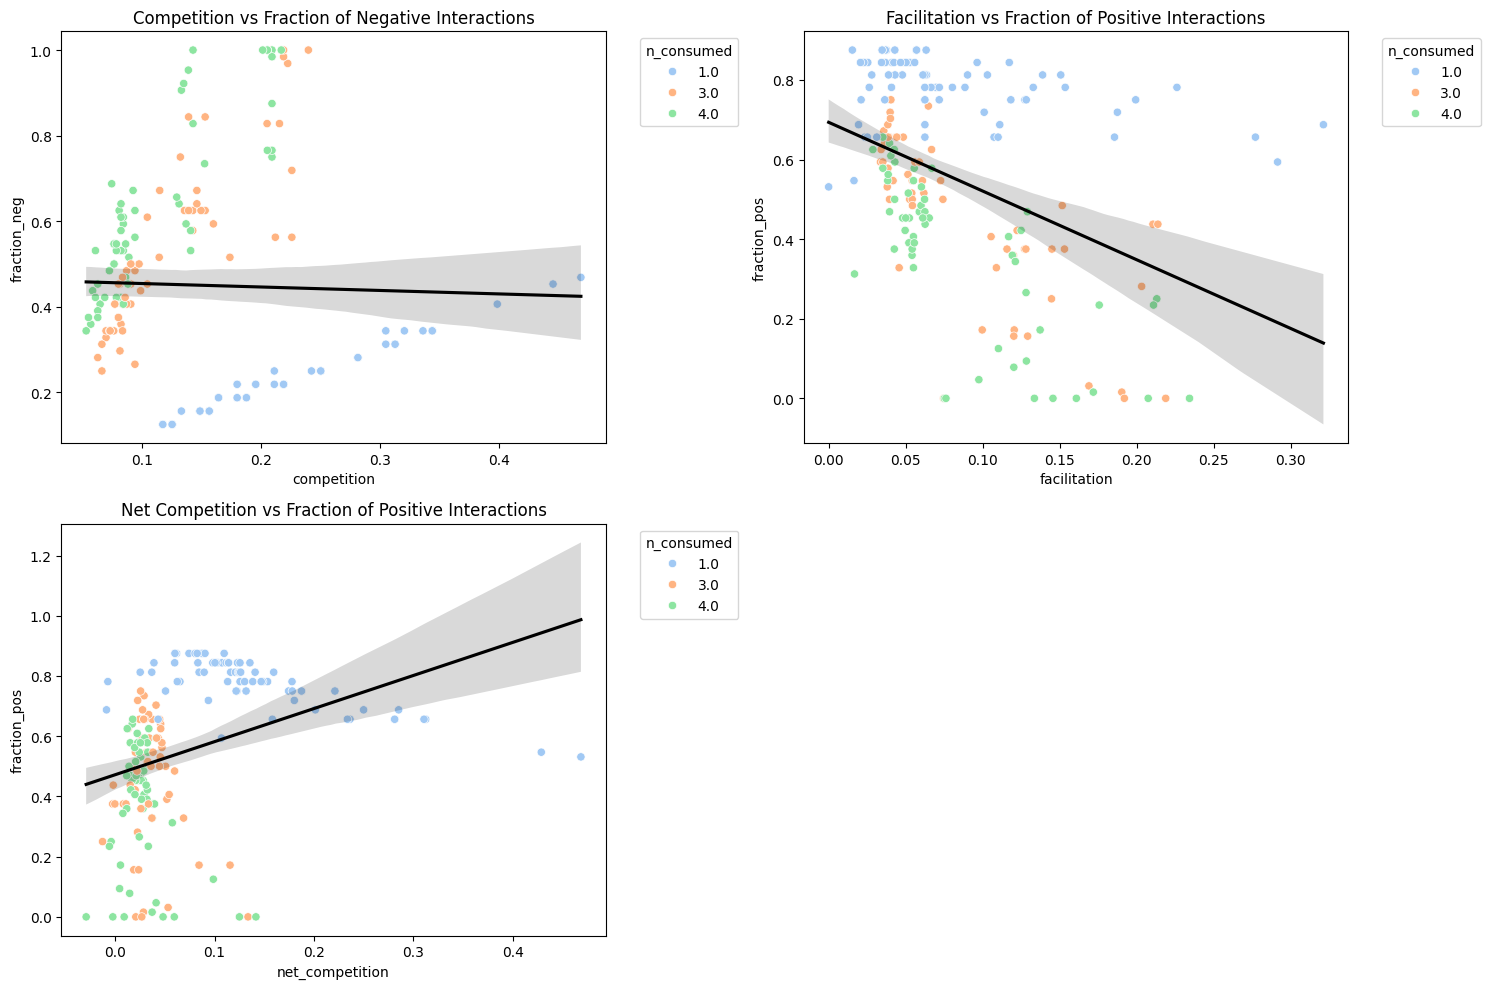

In [23]:
from scipy.stats import pearsonr

# Define a color palette with enough colors for distinct n_resources values
palette = sns.color_palette("pastel", n_colors=merged_df['n_consumed'].nunique())

plt.figure(figsize=(15, 10))

## Competition vs Fraction Negative
plt.subplot(2, 2, 1)
sns.scatterplot(x='competition', y='fraction_neg', hue='n_consumed', data=merged_df, palette=palette, legend='full')
sns.regplot(x='competition', y='fraction_neg', data=merged_df, scatter=False, color='black')
plt.title('Competition vs Fraction of Negative Interactions')
plt.legend(title='n_consumed', bbox_to_anchor=(1.05, 1), loc='upper left')

# Facilitation vs Fraction Positive
plt.subplot(2, 2, 2)
sns.scatterplot(x='facilitation', y='fraction_pos', hue='n_consumed', data=merged_df, palette=palette, legend='full')
sns.regplot(x='facilitation', y='fraction_pos', data=merged_df, scatter=False, color='black')
plt.title('Facilitation vs Fraction of Positive Interactions')
plt.legend(title='n_consumed', bbox_to_anchor=(1.05, 1), loc='upper left')

# Net Competition vs Fraction Positive
plt.subplot(2, 2, 3)
sns.scatterplot(x='net_competition', y='fraction_pos', hue='n_consumed', data=merged_df, palette=palette, legend='full')
sns.regplot(x='net_competition', y='fraction_pos', data=merged_df, scatter=False, color='black')
plt.title('Net Competition vs Fraction of Positive Interactions')
plt.legend(title='n_consumed', bbox_to_anchor=(1.05, 1), loc='upper left')

# Correlation values
print("Pearson correlation (Competition, Fraction Negative):", pearsonr(merged_df['competition'], merged_df['fraction_neg']))
print("Pearson correlation (Facilitation, Fraction Positive):", pearsonr(merged_df['facilitation'], merged_df['fraction_pos']))
print("Pearson correlation (Net Competition, Fraction Positive):", pearsonr(merged_df['net_competition'], merged_df['fraction_pos']))

plt.tight_layout()
plt.show()

# Shannon diversity

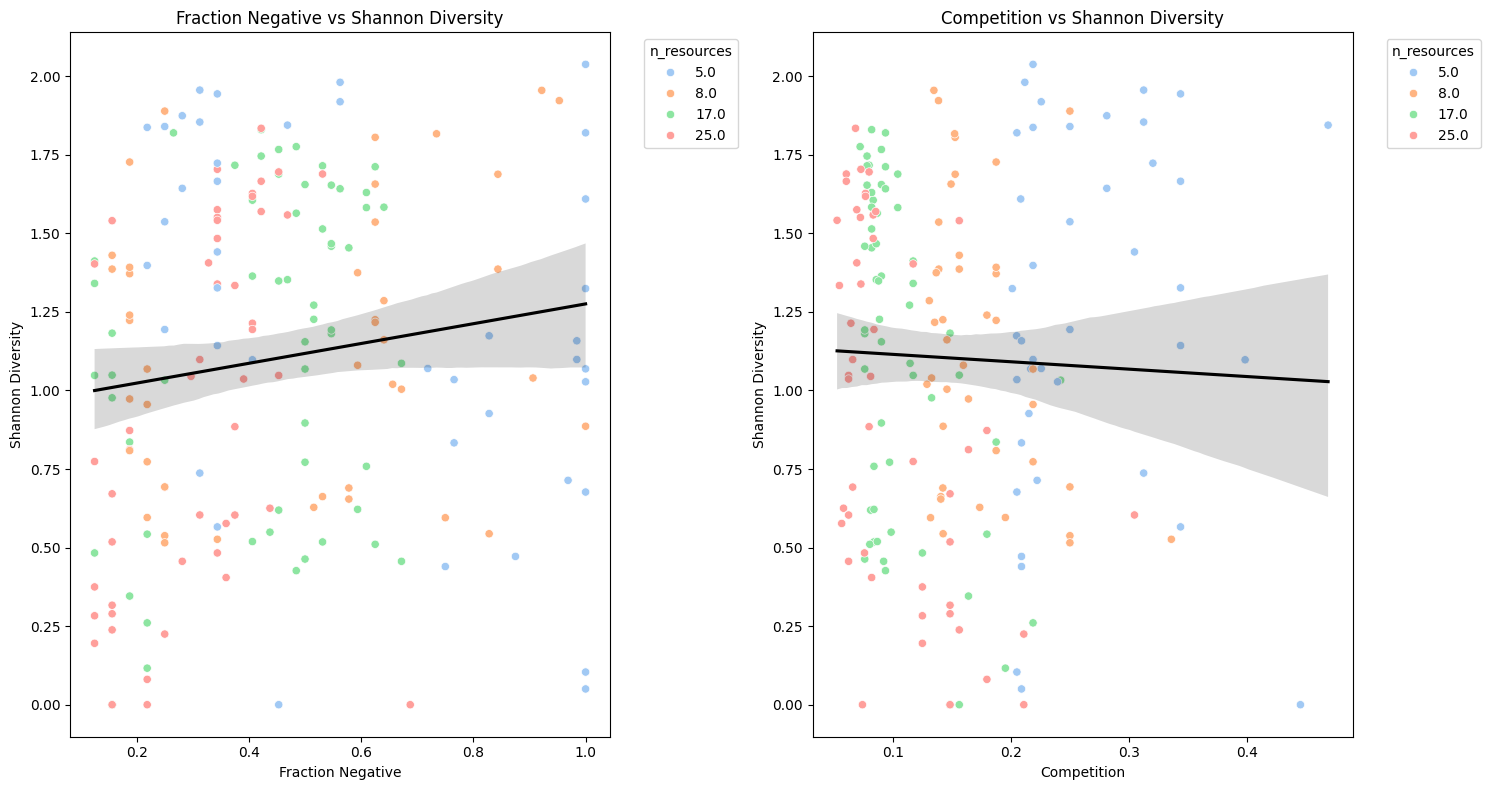

In [24]:

# Ensure df_complete and df_compare are properly aligned
# Assuming that the index of both DataFrames align correctly
merged_df['shannon'] = df_complete['shannon']

# Plotting side by side
plt.figure(figsize=(15, 8))

# Fraction Negative vs Shannon Diversity
plt.subplot(1, 2, 1)
sns.scatterplot(x='fraction_neg', y='shannon', data=merged_df, hue='n_resources', palette='pastel')
sns.regplot(x='fraction_neg', y='shannon', data=merged_df, scatter=False, color='black')
plt.title('Fraction Negative vs Shannon Diversity')
plt.xlabel('Fraction Negative')
plt.ylabel('Shannon Diversity')
plt.legend(title='n_resources', bbox_to_anchor=(1.05, 1), loc='upper left')

# Competition vs Shannon Diversity
plt.subplot(1, 2, 2)
sns.scatterplot(x='competition', y='shannon', data=merged_df, hue='n_resources', palette='pastel')
sns.regplot(x='competition', y='shannon', data=merged_df, scatter=False, color='black')
plt.title('Competition vs Shannon Diversity')
plt.xlabel('Competition')
plt.ylabel('Shannon Diversity')
plt.legend(title='n_resources', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()